In [1]:
%matplotlib nbagg
import jungfrau_utils as ju
import numpy as np
import json, h5py
import os, glob
import time
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import cm
from scipy.optimize import curve_fit
from IPython.display import clear_output, display
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from ipyfilechooser import FileChooser
from scipy.stats.stats import pearsonr

from alvra_tools.load_data import *
from alvra_tools.channels import *
from alvra_tools.utils import *
from alvra_tools.XES_functions import *

import warnings
warnings.filterwarnings('ignore')

In [10]:
savedir = '/das/work/p19/p19262/Claudio/PNG/'
os.makedirs(savedir, exist_ok=True)
print (savedir)

/das/work/p19/p19262/Claudio/PNG/


## First load a few images to identify ROIs and check threshold

In [3]:
pgroup='p19262'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [4]:
nshots = 1000
threshold_low = 2
threshold_high = 10

######################################################################

total_image_on, total_image_thr_on, total_for_hist_on, total_for_hist_thr_on,\
total_image_off, total_image_thr_off, total_for_hist_off, total_for_hist_thr_off = \
XES_pp_full(fc.selected, pgroup, threshold_low, threshold_high, nshots)

Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_011280.JF02T09V02.res.h5
jungfrau file: 11:44 04.12.2021
pedestal file: 09:32 04.12.2021
    mtime difference: 2:12:44.982375
Total images = 1000, load them in batches of 1000
Load batch = slice(0, 1000, None)
Loaded 500 images ON, 500 images OFF
Now summing up 500 images ON&OFF...
It took 40.59 seconds to process this file


<IPython.core.display.Javascript object>


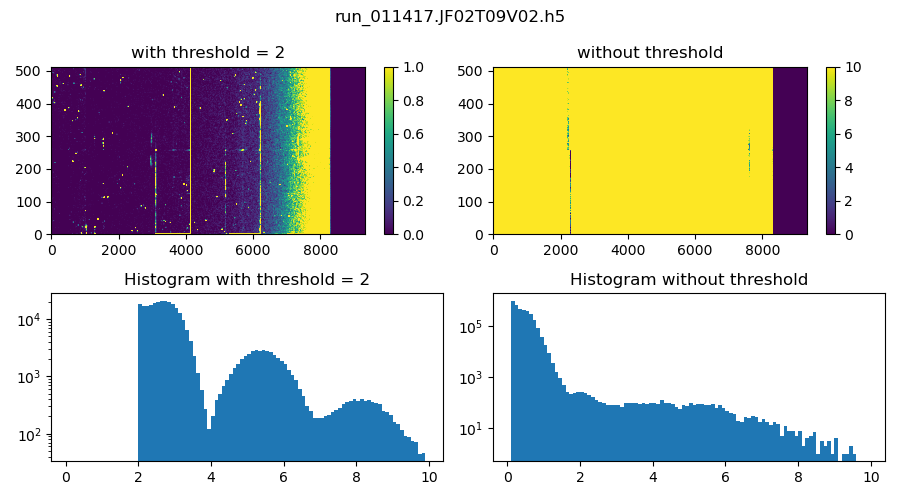

In [5]:
total_image = total_image_on + total_image_off
total_image_thr = total_image_thr_on + total_image_thr_off
total_for_hist = total_for_hist_on + total_for_hist_off
total_for_hist_thr = total_image_thr_on + total_image_thr_off

plt.figure(figsize=(9,5))
plt.suptitle(fc.selected_filename)
plt.subplots_adjust(wspace=0.5)

plt.subplot(221)
plt.imshow(total_image_thr, origin="lower", aspect='auto', vmin=0, vmax=1)
plt.title("with threshold = {}".format(threshold_low))
plt.colorbar()

plt.subplot(223)
plt.title("Histogram with threshold = {}".format(threshold_low))
plt.hist(total_for_hist_thr.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.subplot(222)
plt.imshow(total_image, origin="lower", aspect='auto', vmin=0, vmax=10)
plt.title("without threshold")
plt.colorbar()

plt.subplot(224)
plt.title("Histogram without threshold")
plt.hist(total_for_hist.ravel(), bins=np.arange(0.1,10,0.1))
plt.yscale('log')

plt.tight_layout()
plt.show()

## Check line correction on one ROI

In [5]:
roi1 = (2900, 3100, 180, 260) #signal CRY2 low
roi2 = (2900, 3100, 250, 330) #signal CRY2 up

roi3 = (7300, 7500, 200, 240) #signal CRY1 low
roi4 = (7300, 7500, 270, 310) #signal CRY1 up

chosen_roi = roi1

#########################################
from scipy.signal import find_peaks

cropped_roi_on = crop_roi(total_image_thr_on, chosen_roi)
cropped_roi_off = crop_roi(total_image_thr_off, chosen_roi)

cropped_roi_on_off = cropped_roi_on + cropped_roi_off

maxvalue = np.max(cropped_roi_on_off.sum(axis=0))
refpxl = np.array(find_peaks(cropped_roi_on_off.sum(axis=0), height=maxvalue/2))[0][0]

cropped_roi_on_corrected = line_rectifier(cropped_roi_on, 5, refpxl)
cropped_roi_off_corrected = line_rectifier(cropped_roi_off, 5, refpxl)

<IPython.core.display.Javascript object>


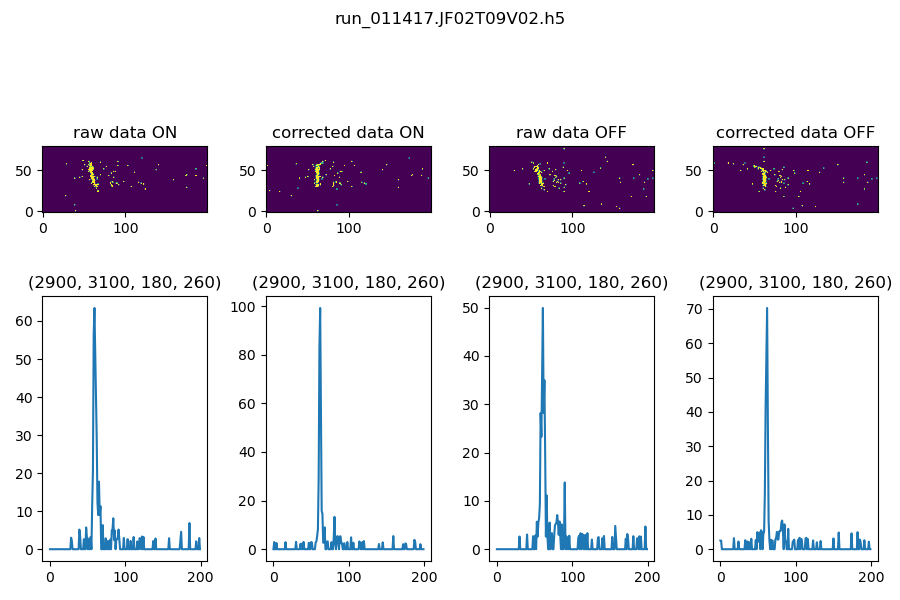

In [21]:
plt.figure(figsize=(9,6))
plt.suptitle(fc.selected_filename)

plt.subplot(241)
plt.title("raw data ON")
plt.imshow(cropped_roi_on,origin= 'lower', vmax = 1)

plt.subplot(242)
plt.title("corrected data ON")
plt.imshow(cropped_roi_on_corrected,origin= 'lower', vmax = 1)

plt.subplot(243)
plt.title("raw data OFF")
plt.imshow(cropped_roi_off,origin= 'lower', vmax = 1)

plt.subplot(244)
plt.title("corrected data OFF")
plt.imshow(cropped_roi_off_corrected,origin= 'lower', vmax = 1)

plt.subplot(245)
plt.title(chosen_roi)
plt.plot(cropped_roi_on.sum(axis=0))

plt.subplot(246)
plt.title(chosen_roi)
plt.plot(cropped_roi_on_corrected.sum(axis=0))

plt.subplot(247)
plt.title(chosen_roi)
plt.plot(cropped_roi_off.sum(axis=0))

plt.subplot(248)
plt.title(chosen_roi)
plt.plot(cropped_roi_off_corrected.sum(axis=0))
plt.show()

plt.tight_layout()

<IPython.core.display.Javascript object>


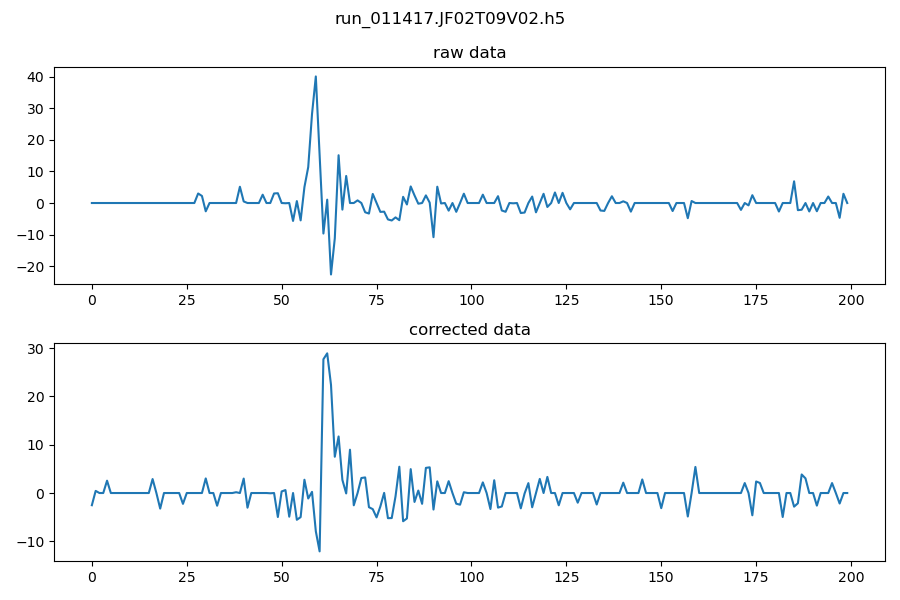

In [20]:
pp = cropped_roi_on.sum(axis=0) - cropped_roi_off.sum(axis=0)
pp_corrected = cropped_roi_on_corrected.sum(axis=0) - cropped_roi_off_corrected.sum(axis=0)

plt.figure(figsize=(9,6))
plt.suptitle(fc.selected_filename)

plt.subplot(211)
plt.title("raw data")
plt.plot(pp)

plt.subplot(212)
plt.title("corrected data")
plt.plot(pp_corrected)

plt.tight_layout()


## Next cells for a single file, ONLY JF file!

In [3]:
pgroup='p19262'
fc = FileChooser(f'/sf/alvra/data/{pgroup}/raw/')
fc.use_dir_icons = True
display(fc)

FileChooser(path='/sf/alvra/data/p19262/raw', filename='', title='HTML(value='', layout=Layout(display='none')…

In [5]:
roi1 = (2900, 3100, 180, 260) #signal CRY2 low
roi2 = (2900, 3100, 250, 330) #signal CRY2 up

roi3 = (7300, 7500, 200, 240) #signal CRY1 low
roi4 = (7300, 7500, 270, 310) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = 5000

correctFlag = (True,True,False,False)
binsize=5

######################################################################################

spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4, pids_ON, \
spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4, pids_OFF =\
XES_PumpProbe_4ROIs(fc.selected, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize)

Processing file run_011417.JF02T09V02.h5
Auto-located gain file: /sf/jungfrau/config/gainMaps/JF02T09V02/gains.h5
Auto-located pedestal file: /sf/alvra/data/p19262/raw/JF_pedestals/run_011280.JF02T09V02.res.h5
jungfrau file: 11:44 04.12.2021
pedestal file: 09:32 04.12.2021
    mtime difference: 2:12:44.982375
Total images = 5000, load them in batches of 1000
Load batch = slice(0, 1000, None)
Load batch = slice(1000, 2000, None)
Load batch = slice(2000, 3000, None)
Load batch = slice(3000, 4000, None)
Load batch = slice(4000, 5000, None)
(2900, 3100, 180, 260) will be corrected
(2900, 3100, 250, 330) will be corrected
(7300, 7500, 200, 240) will remain as it is
(7300, 7500, 270, 310) will remain as it is
Loaded 2500 images ON, 2500 images OFF
It took 23.11 seconds to process this file


<IPython.core.display.Javascript object>


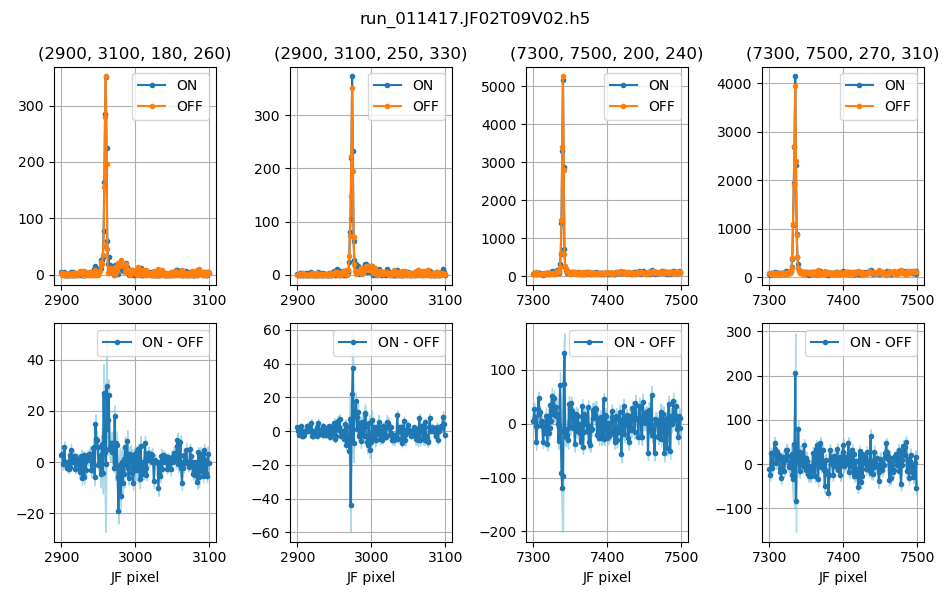

In [8]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle(fc.selected_filename)

binarray = [1,1,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('JF pixel')
    

plt.tight_layout()

## Now with Energy calibration 

In [22]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

<IPython.core.display.Javascript object>


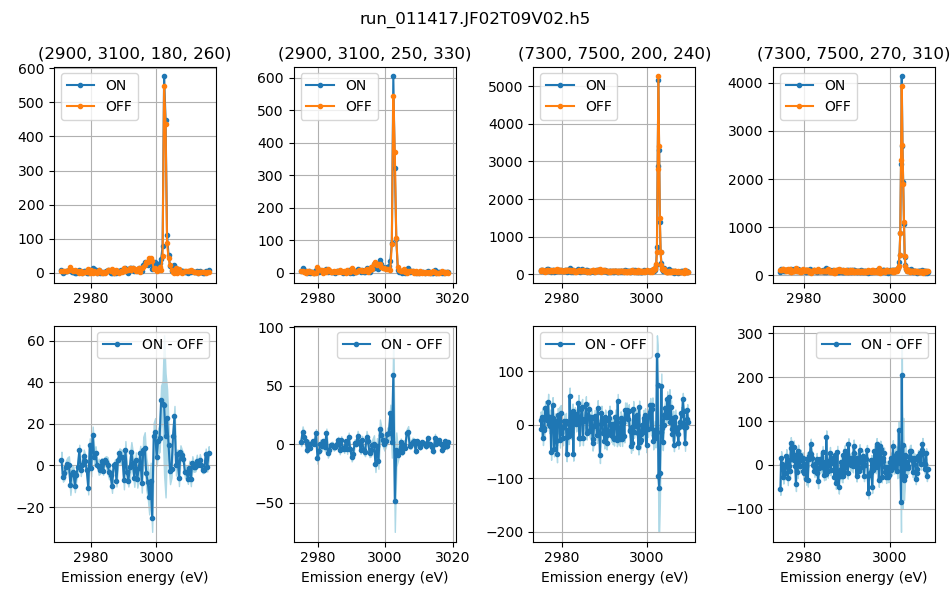

In [6]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle(fc.selected_filename)

binarray = [2,2,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.linspace(roiarray[i][0]*m_all[i]+b_all[i], roiarray[i][1]*m_all[i]+b_all[i], roiarray[i][1]-roiarray[i][0])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('Emission energy (eV)')
    

plt.tight_layout()

## Next cells for a summing up identical file, ONLY JF file!

In [2]:
pgroup='p19262'

datalist = []
for file in glob(f'/sf/alvra/data/{pgroup}/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/*JF*'):
    datalist.append(file)
datalist = sorted(datalist)#, key = os.path.getmtime)
patch = datalist
print (len(patch))
patch

34


['/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011464.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011465.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011466.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011467.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011468.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011469.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011470.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011471.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_250fs_3002p8eV_newCRY1_2/run_011472.JF02T09V02.h5',
 '/sf/alvra/data/p19262/raw/static_data/RIXS_CpRhCO2_25

In [5]:
roi1 = (2900, 3100, 180, 260) #signal CRY2 low
roi2 = (2900, 3100, 250, 330) #signal CRY2 up

roi3 = (7300, 7500, 200, 240) #signal CRY1 low
roi4 = (7300, 7500, 270, 310) #signal CRY1 up

threshold_low = 2
threshold_high = 10
nshots = None

correctFlag = (True,True,False,False)
binsize=5

######################################################################################
from alvra_tools import clock
clock_int = clock.Clock()

spectrum_roi1_ON_all = []
spectrum_roi2_ON_all = []
spectrum_roi3_ON_all = []
spectrum_roi4_ON_all = []
spectrum_roi1_OFF_all = []
spectrum_roi2_OFF_all = []
spectrum_roi3_OFF_all = []
spectrum_roi4_OFF_all = []

for i,JF_single_file in enumerate(patch):
    
    spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4, pids_ON, \
    spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4, pids_OFF =\
    XES_PumpProbe_4ROIs(JF_single_file, pgroup, roi1, roi2, roi3, roi4, threshold_low, threshold_high, nshots, correctFlag, binsize)
    
    spectrum_roi1_ON_all.append(spectrum_ON_roi1)
    spectrum_roi2_ON_all.append(spectrum_ON_roi2)
    spectrum_roi3_ON_all.append(spectrum_ON_roi3)
    spectrum_roi4_ON_all.append(spectrum_ON_roi4)
    spectrum_roi1_OFF_all.append(spectrum_OFF_roi1)
    spectrum_roi2_OFF_all.append(spectrum_OFF_roi2)
    spectrum_roi3_OFF_all.append(spectrum_OFF_roi3)
    spectrum_roi4_OFF_all.append(spectrum_OFF_roi4)
    
    clear_output(wait=True)
    print ('{} files done out of {}'.format(i+1,len(patch)))
    print ("It took", clock_int.tick(), "seconds to process this file")

spectrum_roi1_ON_all = np.asarray(spectrum_roi1_ON_all)
spectrum_roi2_ON_all = np.asarray(spectrum_roi2_ON_all)
spectrum_roi3_ON_all = np.asarray(spectrum_roi3_ON_all)
spectrum_roi4_ON_all = np.asarray(spectrum_roi4_ON_all)
spectrum_roi1_OFF_all = np.asarray(spectrum_roi1_OFF_all)
spectrum_roi2_OFF_all = np.asarray(spectrum_roi2_OFF_all)
spectrum_roi3_OFF_all = np.asarray(spectrum_roi3_OFF_all)
spectrum_roi4_OFF_all = np.asarray(spectrum_roi4_OFF_all)

print ("It took {} seconds to process {} files".format(clock_int.tock(), len(patch)))

34 files done out of 34
It took 5.08 seconds to process this file
It took 905.77 seconds to process 34 files


<IPython.core.display.Javascript object>


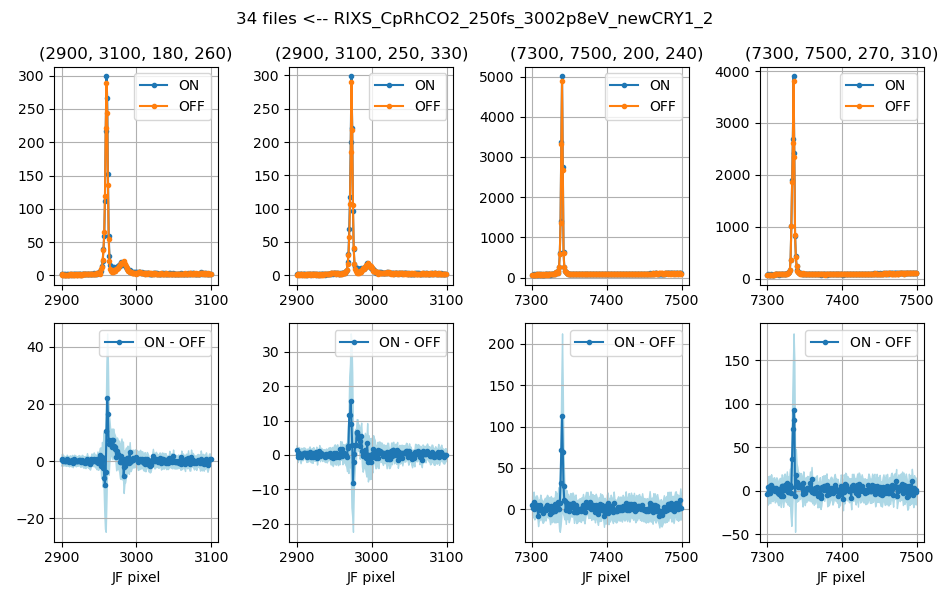

In [12]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle('{} files <-- {}'.format(len(patch),patch[0].split('/')[-2]))

spectrum_ON_roi1 = np.mean(spectrum_roi1_ON_all, axis = 0)
spectrum_ON_roi2 = np.mean(spectrum_roi2_ON_all, axis = 0)
spectrum_ON_roi3 = np.mean(spectrum_roi3_ON_all, axis = 0)
spectrum_ON_roi4 = np.mean(spectrum_roi4_ON_all, axis = 0)
spectrum_OFF_roi1 = np.mean(spectrum_roi1_OFF_all, axis = 0)
spectrum_OFF_roi2 = np.mean(spectrum_roi2_OFF_all, axis = 0)
spectrum_OFF_roi3 = np.mean(spectrum_roi3_OFF_all, axis = 0)
spectrum_OFF_roi4 = np.mean(spectrum_roi4_OFF_all, axis = 0)

binarray = [1,1,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.arange(roiarray[i][0], roiarray[i][1])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.grid()
    plt.xlabel('JF pixel')
    

plt.tight_layout()

## Now with Energy calibration 

In [7]:
m_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_m_all.txt')
b_all = np.loadtxt('/das/work/p19/p19262/JF_XES_calibration/223_XAS_CpRhCO2_250fs.json_b_all.txt')

<IPython.core.display.Javascript object>


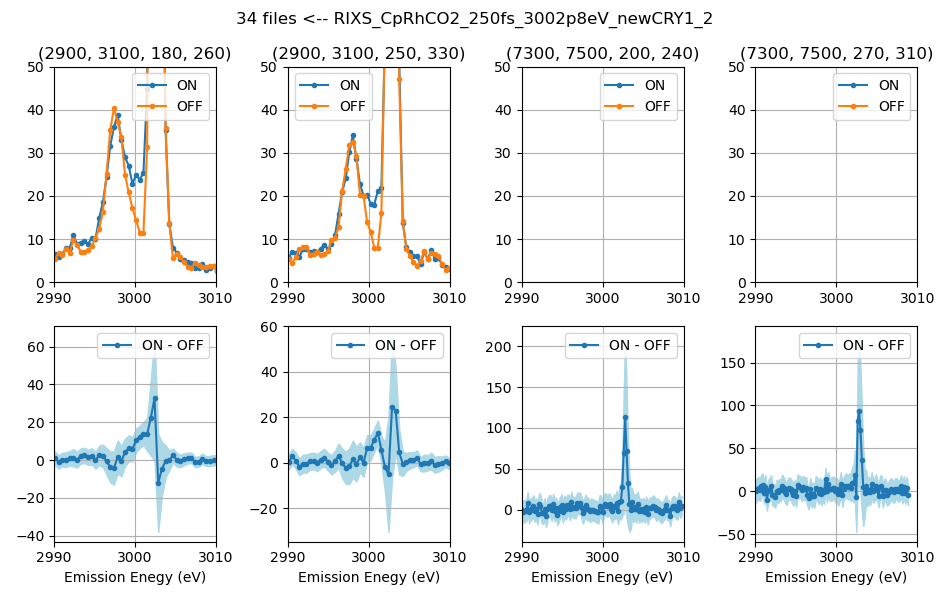

In [13]:
fig = plt.figure(figsize=(9.5, 6))
plt.suptitle('{} files <-- {}'.format(len(patch),patch[0].split('/')[-2]))

spectrum_ON_roi1 = np.mean(spectrum_roi1_ON_all, axis = 0)
spectrum_ON_roi2 = np.mean(spectrum_roi2_ON_all, axis = 0)
spectrum_ON_roi3 = np.mean(spectrum_roi3_ON_all, axis = 0)
spectrum_ON_roi4 = np.mean(spectrum_roi4_ON_all, axis = 0)
spectrum_OFF_roi1 = np.mean(spectrum_roi1_OFF_all, axis = 0)
spectrum_OFF_roi2 = np.mean(spectrum_roi2_OFF_all, axis = 0)
spectrum_OFF_roi3 = np.mean(spectrum_roi3_OFF_all, axis = 0)
spectrum_OFF_roi4 = np.mean(spectrum_roi4_OFF_all, axis = 0)

binarray = [2,2,1,1] # change the bin size if wanted, 1 is every pixel
spectrum_ON_array = [spectrum_ON_roi1, spectrum_ON_roi2, spectrum_ON_roi3, spectrum_ON_roi4]
spectrum_OFF_array = [spectrum_OFF_roi1, spectrum_OFF_roi2, spectrum_OFF_roi3, spectrum_OFF_roi4]
roiarray = [roi1, roi2, roi3, roi4]

for i in range(4):
    x_axis = np.linspace(roiarray[i][0]*m_all[i]+b_all[i], roiarray[i][1]*m_all[i]+b_all[i], roiarray[i][1]-roiarray[i][0])
    x_axis_rebin, spectrum_ON_rebin, spectrum_OFF_rebin, low_err, high_err = plot_tool(spectrum_ON_array[i], spectrum_OFF_array[i], x_axis, binarray[i])
    location = 241+i  # this is to index the position of the subplot
    ax = plt.subplot(location)
    ax.plot(x_axis_rebin,spectrum_ON_rebin, label='ON', marker='.')
    ax.plot(x_axis_rebin,spectrum_OFF_rebin, label='OFF', marker='.')
    plt.legend(loc="best")
    plt.ylim(0,50)
    plt.xlim(2990,3010)
    plt.grid()
    ax.set_title(str(roiarray[i]))
    
    location2 = 245+i  # this is to index the position of the subplot
    ax2 = plt.subplot(location2)
    ax2.plot(x_axis_rebin, spectrum_ON_rebin - spectrum_OFF_rebin, label="ON - OFF",marker='.')
    ax2.fill_between(x_axis_rebin, low_err, high_err, color='lightblue')
    plt.legend(loc="best")
    plt.xlim(2990,3010)
    plt.grid()
    plt.xlabel('Emission Enegy (eV)')
    
plt.tight_layout()

#plt.savefig(savedir + patch[0].split('/')[-2] + '_corrected.png')

In [ ]:
outdir = '/das/work/p18/p18442/Exported_data/'
filename_h5 = outdir + scan_name + "_export.h5" 
with h5py.File(filename_h5, "w") as file2write:
    file2write.create_dataset("energy_eV", data = Energy_eV)
    file2write.create_dataset("roi1", data = roi1)
    file2write.create_dataset("pump_roi1", data = RIXS_pumped_roi1)
    file2write.create_dataset("unpump_roi1", data = RIXS_unpumped_roi1)
    file2write.create_dataset("transient_roi1", data = RIXS_transient_roi1)
    file2write.create_dataset("roi2", data = roi2)
    file2write.create_dataset("pump_roi2", data = RIXS_pumped_roi2)
    file2write.create_dataset("unpump_roi2", data = RIXS_unpumped_roi2)
    file2write.create_dataset("transient_roi2", data = RIXS_transient_roi2)

print(filename_h5)

In [ ]:
scan_name_load = 'RuBpy_RIXS_6'

##########################################################

outdir = '/das/work/p18/p18442/Exported_data/'
fn = outdir + scan_name_load + "_export.h5" 
print (fn)
with h5py.File(fn, "r") as file2open:
    Energy_eV = file2open['energy_eV'][:]
    roi1 = file2open['roi1'][:]
    RIXS_pumped_roi1 = file2open['pump_roi1'][:]
    RIXS_unpumped_roi1 = file2open['unpump_roi1'][:]
    RIXS_transient_roi1 = file2open['transient_roi1'][:]
    roi2 = file2open['roi2'][:]
    RIXS_pumped_roi2 = file2open['pump_roi2'][:]
    RIXS_unpumped_roi2 = file2open['unpump_roi2'][:]
    RIXS_transient_roi2 = file2open['transient_roi2'][:]

<IPython.core.display.Javascript object>


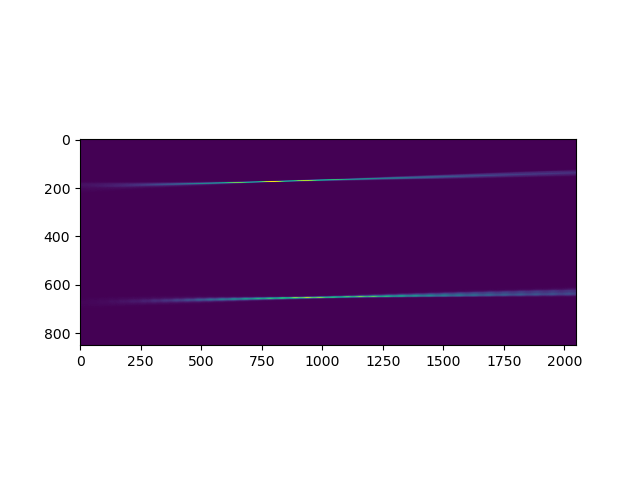

In [7]:
with SFDataFiles("/sf/alvra/data/p18938/raw/scan_data/SiN_timing_NOPA_shortX_loop3_000/run_014886.CAMERAS.h5") as sfd:
    ch = sfd['SARES11-SPEC125-M2:FPICTURE']
    img = ch.data[0]

plt.imshow(img)